##Introduction
Food image recognition, pivotal in computer-aided dietary assessment, stands as a cornerstone for health monitoring and nutrition management. This project endeavors not only to explore this domain but to surpass the benchmark set by the pioneering work of [DeepFood: Deep Learning-Based Food Image Recognition for Computer-Aided Dietary Assessment](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment).

At the heart of this pursuit lies the Food 101 dataset, a comprehensive repository hosting diverse food categories captured through images. Inspired by the achievements of the DeepFood paper, which attained a notable top-1 accuracy of 77.4%.

Central to this endeavor is the utilization of transfer learning, leveraging the powerful pre-trained EfficientNetB0 model. Initially employed for feature extraction, this methodology aims to capture intricate food features effectively. Subsequently, fine-tuning strategies will be applied, tailoring the model's parameters to the nuances of the Food 101 dataset. Ultimately, the main goal of this project is to beat the top-1 accuracy of 77.4% which the paper reasearchers obtained.

We will start by loading the data from TensorFlow datasets. This dataset comes in the form of training and validation data so we will split it accordingly. Also, by setting the as_supervised argument as True the data will be loaded as tuples including the image tensor and the label.

In [ ]:
# Loading the food 101 dataset
import tensorflow_datasets as tfds

(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train','validation'],
                                             batch_size=32,
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.4Q6U56_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.4Q6U56_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


Now that the data has been loaded from the TensorFlow datasets, we take a look at the meta data available.

In [ ]:
# Looking at the food 101 meta data
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir=PosixGPath('/tmp/tmpl_g6m4qitfds'),
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examp

By checking a sample of the data we will see that the images are in in uint8 datatype and the are not of the same tensor size.

In [ ]:
# Taking one batch of the data
training_sample = train_data.take(2)

# Output info about our training sample
for image, label in training_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
        """)


  Image shape: (32, 512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): [90 93 37 66 72 73  3 89  5 30  8  2 26 76  3 80 65 10  4 28 86 25 67 59
 79  3 13  3 87 98  4 58]
        

  Image shape: (32, 512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): [47 97 83 57  1 85 23 30 54 11 50 61 23 96 14 47 76 84 70 15 89 27 93  7
  8 65 42 45 53 56 90 54]
        


# Pre-processing and Preparing the data

In order to preprocess the data, we write a function which will:


*   Change the datatype to float32
*   Reshape the tensors to be of the same size

Since we are going to use EfficientNetB0 and because pretrained EfficientNetBX models have rescaling built-in within them, it is not needed to include rescaling or normalization in our pre-processing function.






In [ ]:
import tensorflow as tf

# Creating a preporcessing function
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

The data will turn into batches of size 32 of image and labels to fit in the memory og the GPU. In order to speed up the training process we will utilize prefetching which is a method that will allow the CPU to prepare the batches as the GPU is being used to save time and increase efficiency.

The picture below which depicts the prefetching method, is from Page 422 of Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron.

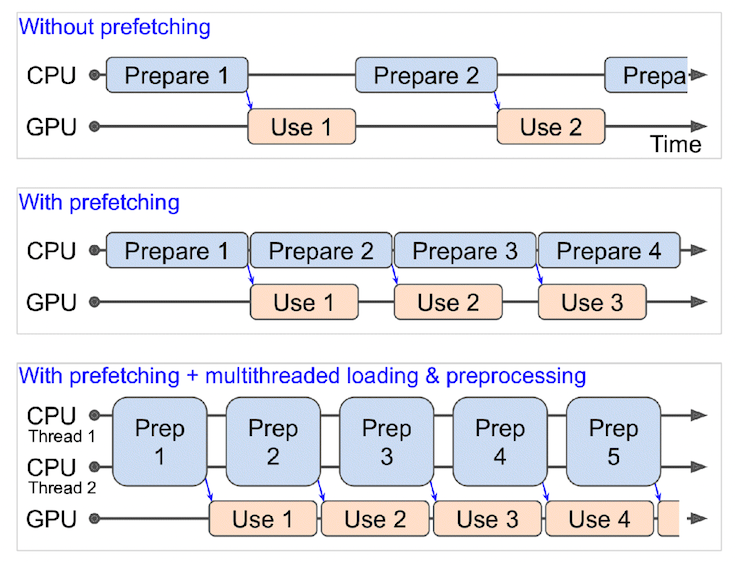

In [ ]:
# Preparing the data
# Mapping the preprocessing function to the taining data
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Prefetching the data
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

# Mapping the preprocessing function to the test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Prefetching the test data
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)


Since we are working with large amounts of data, before creating a model we create callbacks to store the logs on tensorboard and also create checkpoints. Additionally, we create an early stopping callback as our model's stopping condition.

In [ ]:
# Creating call backs for training
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Model checkpoint callback
checkpoint_path = "model_checkpoints/cp.keras"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      verbose=0)
# Early stoppig callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3,
                                                  restore_best_weights=True)

Using mixed percision training can help increase the speed and efficiency of the training process. Therefore, we use mixed percision with float16.

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

Adding a data augmentation layer could improve the model's performance on unseen data. This layer will randomly rotate and zoom on the images in the dataset.

In [ ]:
# Create a data augmentation layer

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# Creating and training the models

Due to the large size of our data we have decided to use a pretrained model, the EfficientNetB0. Firstly, we create and train a feature extraction model by adding a pooling and an output layer to the pretrained model, and we will freeze the weights and biases in the top layers and only train the layers we have added. Later on, we will fine tune the model by unfreezing the top layers and trying to improve the performance of the model.

In [ ]:
from tensorflow.keras import layers

# Create base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the feature extraction model
input_shape = (224, 224, 3)
inputs = layers.Input(shape=input_shape, name='input_layer')
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='pooling_layer')(x)
x = layers.Dense(101)(x)
outputs = layers.Activation('softmax', dtype=tf.dtypes.float32, name='softmax_float32')(x)
feature_extraction_model = tf.keras.Model(inputs, outputs)

# Compile the model
feature_extraction_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                                 optimizer=tf.keras.optimizers.Adam(0.001),
                                 metrics=['accuracy'])

feature_extraction_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_layer                        │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 101)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Fitting the feature extraction model
feature_extraction_history = feature_extraction_model.fit(train_data,
                                                          validation_data=test_data,
                                                          validation_steps=int(0.15*len(test_data)),
                                                          epochs=5,
                                                          callbacks=[create_tensorboard_callback('Models', 'feature_extraction_model'), model_checkpoint],
                                                          )

Saving TensorBoard log files to: Models/feature_extraction_model/20241116-171456
Epoch 1/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 249s 94ms/step - accuracy: 0.4278 - loss: 2.4772 - val_accuracy: 0.6351 - val_loss: 1.3646
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 217s 82ms/step - accuracy: 0.6212 - loss: 1.4815 - val_accuracy: 0.6711 - val_loss: 1.2366
Epoch 3/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 218s 89ms/step - accuracy: 0.6571 - loss: 1.3230 - val_accuracy: 0.6798 - val_loss: 1.1806
Epoch 4/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 193s 81ms/step - accuracy: 0.6777 - loss: 1.2352 - val_accuracy: 0.6915 - val_loss: 1.1567
Epoch 5/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 225s 91ms/step - accuracy: 0.6935 - loss: 1.1634 - val_accuracy: 0.6944 - val_loss: 1.1430


In [ ]:
model_accuracy = feature_extraction_model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 61s 77ms/step - accuracy: 0.6865 - loss: 1.1636


In [ ]:
feature_extraction_model.save('feature_extraction_model.keras')

Since our model has so far failed to beat the top-1 accuracy that we were trying to beat we will set all the layers to be trainable and fine tune the model to improve performance.

In [ ]:
for layer in feature_extraction_model.layers:
    layer.trainable = True # set all layers to trainable

Adding a learning rate reduction callback will help with the convergence of the model in training.

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [ ]:
# Compile the model
feature_extraction_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [ ]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = feature_extraction_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20241116-174620
Epoch 1/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6127 - loss: 1.5112

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 404s 124ms/step - accuracy: 0.6127 - loss: 1.5111 - val_accuracy: 0.7775 - val_loss: 0.8136 - learning_rate: 1.0000e-04
Epoch 2/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7767 - val_loss: 0.8020 - learning_rate: 1.0000e-04
Epoch 3/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 244s 103ms/step - accuracy: 0.7986 - loss: 0.7461 - val_accuracy: 0.8016 - val_loss: 0.7165 - learning_rate: 1.0000e-04
Epoch 4/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7998 - val_loss: 0.7204 - learning_rate: 1.0000e-04
Epoch 5/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 254s 102ms/step - accuracy: 0.8657 - loss: 0.5040 - val_accuracy: 0.8075 - val_loss: 0.7103 - learning_rate: 1.0000e-04
Epoch 6/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8051 - val_loss: 0.7278 - learning_rate: 1.0000e-04
Epoch 7/100
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9157 - loss: 0.3324
Epoch 7: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 ━━━━━━━

In [ ]:
fine_tuned_model_accuracy = feature_extraction_model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 57s 71ms/step - accuracy: 0.8030 - loss: 0.7169


The final fine tuned model achieved 80 percent accuracy on the test data set beating the original paper.